In [1]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import os
import shutil
from tqdm.auto import tqdm
from IPython.display import clear_output

/home/ubuntu/anaconda3/envs/smartpot/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
root_dir = '/home/lab38/images/딸기_해충'

In [3]:
images = os.listdir(root_dir)
print(images.__len__())

185


In [4]:
img_list = []
grow = []

# Image Selecting

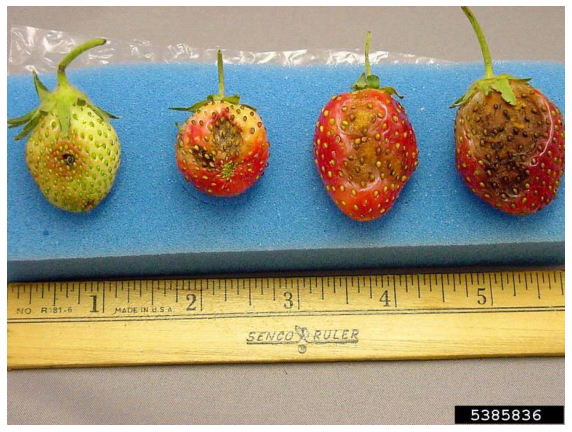

학습에 사용할 이미지면 y :n


In [7]:
for image in images :
    try :
        path = os.path.join(root_dir, image)
        img = plt.imread(path)
        plt.figure(figsize=(10,10))
        plt.imshow(img)
        plt.axis('off')
        plt.show()
    except :
        continue
    while True :
        c = input('학습에 사용할 이미지면 y :')
        if c=='y':
            img_list.append(image)
            while True :
                g = int(input('성장단계 1~5: '))
                if g >0 and g<=5 :
                    grow.append(g)
                    break
                else :
                    print('Typo!')
            break
        elif c=='n' :
            break
        else: 
            print('Typo!') 
    clear_output(wait=True)

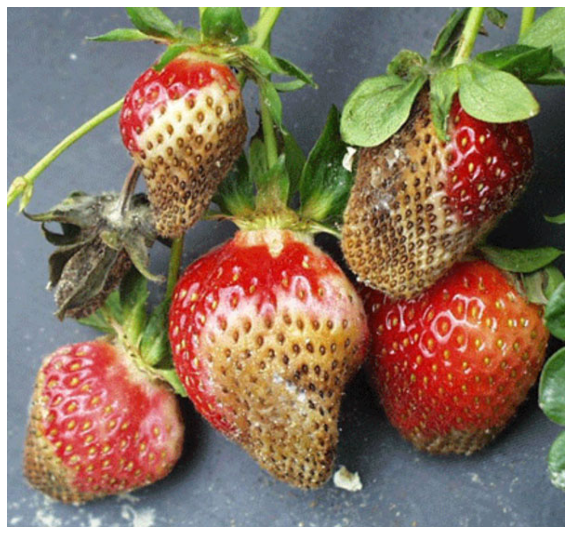

학습에 사용할 이미지면 y :y
성장단계 1~5: 5


In [40]:
# labeling double check
remove_list=[]
grow = []
for i,image in enumerate(img_list) :
    try :
        path = os.path.join(root_dir, image)
        img = plt.imread(path)
        plt.figure(figsize=(10,10))
        plt.imshow(img)
        plt.axis('off')
        plt.show()
    except :
        continue
    while True :
        c = input('학습에 사용할 이미지면 y :')
        if c=='y':
            while True :
                g = int(input('성장단계 1~5: '))
                if g >0 and g<=5 :
                    grow.append(g)
                    break
                else :
                    print('Typo!')
            break
        elif c=='n' :
            remove_list.append(image)
            break
        else: 
            print('Typo!') 
    clear_output(wait=True)

In [41]:
remove_list

[]

In [43]:
len(img_list)

59

In [44]:
result = pd.DataFrame({'image' : img_list,
                      'grow' : grow})
print(result.__len__())
result.head()

59


,image,grow
0,Strawberry Pest Damage_3.jpg,5
1,Strawberry Pest Damage_727.jpg,2
2,Strawberry Pest Damage_487.jpg,5
3,Strawberry Pest Damage_124.jpg,5
4,Strawberry Pest Damage_70.jpg,5


In [45]:
result['grow'].unique()

array([5, 2, 4, 1, 3])

In [46]:
result.groupby('grow').size()

grow
1     1
2    16
3     1
4    16
5    25
dtype: int64

In [47]:
import albumentations as A

transform = A.Compose([
    A.RandomCrop(width=256, height=256),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.OneOf([
        A.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        A.GridDistortion(p=0.5),
        A.OpticalDistortion(distort_limit=1, shift_limit=0.5, p=1),
    ], p=0.8)
])

In [48]:
result.loc[0,'grow']

5

In [49]:
root_dir = '/home/lab38/images/딸기_해충'
folder_dir = '/home/lab38/딸기'

aug_img_list = []
aug_grow = []

for idx, img_name in enumerate(tqdm(result['image'])):
    from_dir = os.path.join(root_dir, img_name)
    
    img = plt.imread(from_dir)
    img = cv2.resize(img, dsize=(320,320))
    plt.imsave(os.path.join(folder_dir, img_name), img)
    grow_label = result.loc[idx, 'grow']
    
    if result.loc[idx, 'grow'] in [1,3] :
        n = 5
    else :
        n = 2
    # augmentation
    for i in range(n) :
        aug_img = transform(image=img)
        aug_img = aug_img['image']
        aug_img_name = img_name.split('.')[0]+'_a'+str(i)+'.'+img_name.split('.')[-1]
        
        # labeling
        aug_img_list.append(aug_img_name)
        aug_grow.append(grow_label)
        
        #img save
        plt.imsave(os.path.join(folder_dir, aug_img_name), aug_img)

100%|███████████████████████████████████████████| 59/59 [00:03<00:00, 19.18it/s]


In [50]:
total_img = result['image'].to_list() + aug_img_list
print(len(total_img))
total_grow = result['grow'].to_list() + aug_grow
print(len(total_grow))

183
183


In [51]:
aug_result = pd.DataFrame({'image' : total_img,
                      'grow' : total_grow})
print(aug_result.__len__())
aug_result.head()

183


,image,grow
0,Strawberry Pest Damage_3.jpg,5
1,Strawberry Pest Damage_727.jpg,2
2,Strawberry Pest Damage_487.jpg,5
3,Strawberry Pest Damage_124.jpg,5
4,Strawberry Pest Damage_70.jpg,5


In [52]:
aug_result['image'] = aug_result['image'].map(lambda x: os.path.join(folder_dir, x))
aug_result['disease'] = 11
aug_result.head()

,image,grow,disease
0,/home/lab38/딸기/Strawberry Pest Damage_3.jpg,5,11
1,/home/lab38/딸기/Strawberry Pest Damage_727.jpg,2,11
2,/home/lab38/딸기/Strawberry Pest Damage_487.jpg,5,11
3,/home/lab38/딸기/Strawberry Pest Damage_124.jpg,5,11
4,/home/lab38/딸기/Strawberry Pest Damage_70.jpg,5,11


In [53]:
straw = pd.read_csv('/home/lab38/Multi_proj_6/data/strawberry_smallsizeimg.csv')
straw.head()

,image,disease,area,grow,points,original,disease-grow
0,/home/lab38/딸기/V006_77_0_00_04_01_13_0_b02_202...,0,1,5,"[{'xtl': 1003, 'ytl': 1167, 'xbr': 2255, 'ybr'...",NaN,0-5
1,/home/lab38/딸기/V006_77_0_00_04_01_13_0_b02_202...,0,1,5,"[{'xtl': 1003, 'ytl': 1217, 'xbr': 2503, 'ybr'...",NaN,0-5
2,/home/lab38/딸기/V006_77_0_00_04_01_13_0_b02_202...,0,1,5,"[{'xtl': 370, 'ytl': 884, 'xbr': 1994, 'ybr': ...",NaN,0-5
3,/home/lab38/딸기/V006_77_0_00_04_01_13_0_b02_202...,0,1,5,"[{'xtl': 739, 'ytl': 1184, 'xbr': 2176, 'ybr':...",NaN,0-5
4,/home/lab38/딸기/V006_77_0_00_04_01_13_0_b02_202...,0,1,5,"[{'xtl': 1031, 'ytl': 1271, 'xbr': 2425, 'ybr'...",NaN,0-5


In [54]:
straw['grow'].unique()

array([5, 4, 3, 2, 1])

In [55]:
straw['disease'].unique()

array([0, 7, 8])

In [58]:
new_straw = pd.concat([aug_result, straw])
new_straw.head(-5)

,image,grow,disease,area,points,original,disease-grow
0,/home/lab38/딸기/Strawberry Pest Damage_3.jpg,5,11,NaN,NaN,NaN,NaN
1,/home/lab38/딸기/Strawberry Pest Damage_727.jpg,2,11,NaN,NaN,NaN,NaN
2,/home/lab38/딸기/Strawberry Pest Damage_487.jpg,5,11,NaN,NaN,NaN,NaN
3,/home/lab38/딸기/Strawberry Pest Damage_124.jpg,5,11,NaN,NaN,NaN,NaN
4,/home/lab38/딸기/Strawberry Pest Damage_70.jpg,5,11,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
16604,/home/lab38/딸기/V006_77_1_08_04_03_12_1_3742w_2...,1,7,3.0,"[{'xtl': 0, 'ytl': 210, 'xbr': 1903, 'ybr': 40...",V006_77_1_08_04_03_12_1_3742w_20201118_8.jpg,7-1
16605,/home/lab38/딸기/V006_77_1_08_04_03_13_1_6135w_2...,1,7,3.0,"[{'xtl': 93, 'ytl': 497, 'xbr': 1048, 'ybr': 2...",V006_77_1_08_04_03_13_1_6135w_20201118_9.jpg,7-1
16606,/home/lab38/딸기/V006_77_1_08_04_03_13_1_6135w_2...,1,7,3.0,"[{'xtl': 93, 'ytl': 63, 'xbr': 1048, 'ybr': 15...",V006_77_1_08_04_03_13_1_6135w_20201118_9.jpg,7-1
16607,/home/lab38/딸기/V006_77_1_08_04_03_13_1_6135w_2...,1,7,3.0,"[{'xtl': 63, 'ytl': 93, 'xbr': 1567, 'ybr': 10...",V006_77_1_08_04_03_13_1_6135w_20201118_9.jpg,7-1


In [59]:
new_straw.to_csv('/home/lab38/Multi_proj_6/data/straw_smallsizeimg_with_pest.csv', index=False)